run KNN algorithm,
First, load the images

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Function to load and convert image to pixel data
def image_to_pixels(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure the image is in RGB mode
    img_array = np.array(img)  # Convert image to NumPy array
    img_array_flattened = img_array.flatten()  # Flatten the array
    return img_array_flattened.tolist()  # Convert flattened array to a list


def listImgDir(directory, imagesLimit = False):
    imagesPath = []
    if(imagesLimit) :
        filenames = os.listdir(directory)[:imagesLimit]
    else :
        filenames = os.listdir(directory)
    for filename in filenames:
        if filename.endswith('.jpg'): # Adjust file extensions as needed
             imagesPath.append(os.path.join(directory, filename))    
    return imagesPath    

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

#load images paths
beansImages = {}
labels_data = ['angular_leaf_spot', 'bean_rust', 'healthy']
for label in labels_data:
    directory = 'dataset beans/train/' + label
    beansImages[label] = listImgDir(directory)
    print (f"Total of {label} leaves: {len(beansImages[label])}")

Total of angular_leaf_spot leaves: 345
Total of bean_rust leaves: 348
Total of healthy leaves: 341


KNN algorithm need the scale (width and heigth) will be same, lets check the width and height

In [23]:
widths = []
heights = []

for label, beansImagesByLabel in beansImages.items():
    for beanImage in beansImagesByLabel:
        width, height = get_image_size(beanImage)
        widths.append(width)
        heights.append(height)
print(widths)
print(heights)

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,

as we can see all widths and heights are equals to 500, we dont need to resize images to scale the image

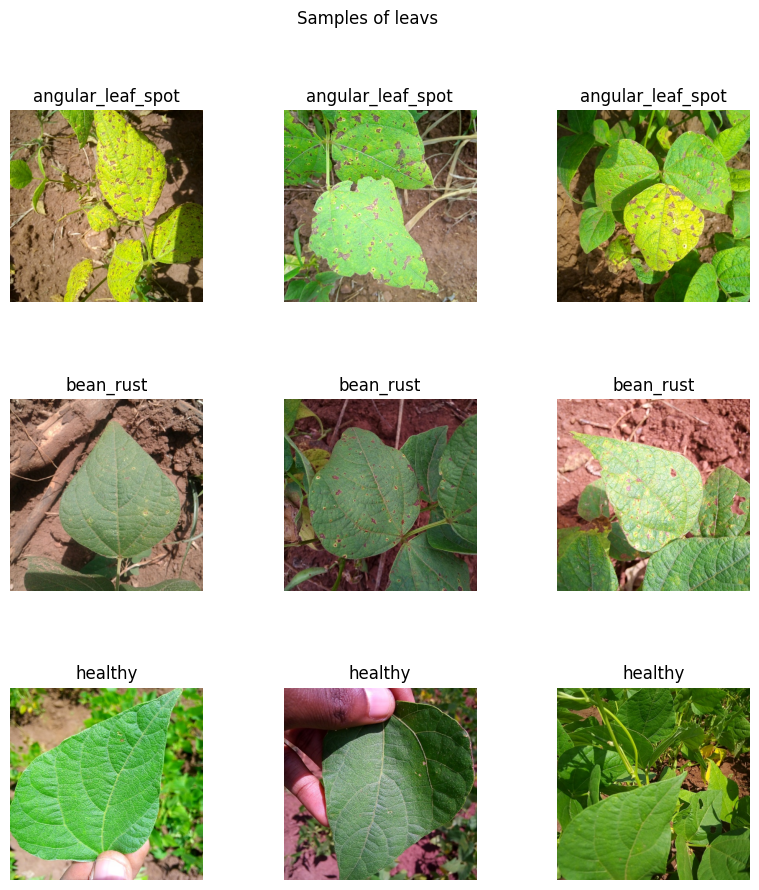

In [30]:
import random

def plot_sample_images():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Samples of leavs')
    for i, label in enumerate(beansImages.keys()):
        for j in range(3):
            random_image = random.randint(0, len(beansImages[label]) -1)	
            img_path = beansImages[label][random_image]
            img = plt.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)
    plt.show()
plot_sample_images()

In [32]:
#run the knn algorithm.
X = []
y = []
#convert the image to array of pixels
for label, beansImagesByLabel in beansImages.items():
    for beanImage in beansImagesByLabel:
        X.append(image_to_pixels(beanImage))
        y.append(label)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5120772946859904


The resulet is not good. this is because the leavs are very similar to each and the diffrents between groups are tiny, Knn algorithm dont sucsees to recognize the diffrent inside leaf,
the algorithm check the changes in all the image, we need first to clear the image noice, and isolate the leaf from background.

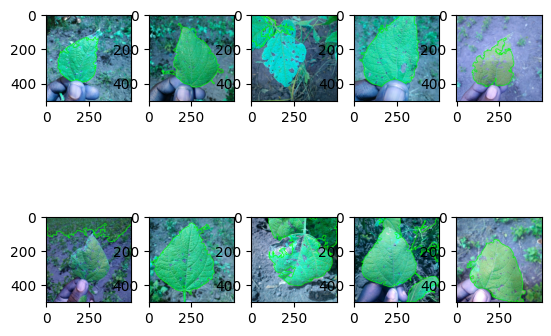

In [10]:
import cv2
def identifyLeaf(imagePath):
    image = cv2.imread(imagePath)
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range of green color in HSV
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Bitwise-AND mask and original image
    green_object = cv2.bitwise_and(image, image, mask=mask)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (main object)
    main_contour = max(contours, key=cv2.contourArea)

    # Draw the contour of the main object
    cv2.drawContours(image, [main_contour], -1, (0, 255, 0), 2)
    return image

onlyLeavsImages = []
for label, beansImagesByLabel in beansImages.items():
    for beanImage in beansImagesByLabel[:10]:
        onlyLeavsImages.append(identifyLeaf(beanImage))
# Load the image
f, axarr = plt.subplots(2,5)
#for beanLeafImage in onlyLeavsImages[:10]:
axarr[0,0].imshow(onlyLeavsImages[0])
axarr[0,1].imshow(onlyLeavsImages[1])
axarr[0,2].imshow(onlyLeavsImages[2])
axarr[0,3].imshow(onlyLeavsImages[3])
axarr[0,4].imshow(onlyLeavsImages[4])
axarr[1,0].imshow(onlyLeavsImages[5])
axarr[1,1].imshow(onlyLeavsImages[6])
axarr[1,2].imshow(onlyLeavsImages[7])
axarr[1,3].imshow(onlyLeavsImages[8])
axarr[1,4].imshow(onlyLeavsImages[9])
plt.show()



